In [1]:
from collections.abc import Iterable
from itertools import pairwise, chain
from typing import Callable

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import torch
import torchvision
import tqdm.auto as tqdm
from torch import nn
import math
from torch.distributions.multivariate_normal import MultivariateNormal

%env KERAS_BACKEND=torch

import keras
from keras import layers
import keras_tuner

env: KERAS_BACKEND=torch


In [2]:
# Move to project root
from pathlib import Path
import os

if not Path("./src/kernels").is_dir():
    for parent_path in Path.cwd().parents:
        if (parent_path / "src/kernels").is_dir():
            os.chdir(parent_path)
            break
    else:
        raise FileNotFoundError("Can't find project root")

assert Path("./src/kernels").is_dir()

In [3]:
from src import kernels, convolutions
from src.models.gangoly_cifar import gangoly_cifar
from src import load_data

In [4]:
import importlib
# from src.kernels import quadratic as quad_kernels
import src.models.gangoly_cifar

importlib.reload(src.models.gangoly_cifar)
from src.models.gangoly_cifar import gangoly_cifar
# kernels = importlib.reload(kernels)
# convolutions = importlib.reload(convolutions)

In [5]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [6]:
cf10 = load_data.cifar10()
cf10

Dataset(x_train=(50000, 3, 32, 32), x_test=(10000, 3, 32, 32), y_train=(50000,), y_test=(10000,))

In [7]:
torch.cuda.empty_cache()
test_hp = keras_tuner.HyperParameters()
test_hp.Fixed("quadratic-pool-kernel", "quadratic-multi")
test_model = gangoly_cifar(img_channels=3)(test_hp)
test_model.compile(optimizer=keras.optimizers.SGD(), loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                   metrics=['accuracy'])
print(test_model(cf10.x_train[:10]))
# test_model.summary()

tensor([[ 6.5395e-03, -2.6387e-03, -5.9461e-03,  1.1779e-03,  2.2543e-03,
          6.5091e-03,  3.3095e-05,  2.3410e-03, -4.7195e-03,  2.9024e-03],
        [ 3.9088e-03, -3.8367e-03, -8.0519e-03, -1.3857e-03,  7.0727e-04,
          9.5566e-03,  2.3674e-03, -4.4193e-04, -5.6332e-04,  2.0046e-03],
        [ 6.9763e-03, -3.7204e-03, -7.2208e-03, -1.5890e-03,  1.7072e-03,
          4.5307e-03,  5.9763e-04,  4.6270e-03, -4.1255e-03, -4.6786e-03],
        [ 3.7230e-03, -2.4647e-03, -6.8281e-03, -1.3335e-03,  4.7707e-04,
          4.3426e-03, -2.4055e-03, -2.5862e-03, -1.4317e-03, -4.5597e-03],
        [ 6.7560e-03, -5.3726e-03, -9.3235e-03, -2.7065e-03,  1.5184e-03,
          1.1461e-02,  2.9179e-03, -1.9500e-03,  1.5905e-03,  6.6346e-04],
        [ 1.1099e-02, -2.2293e-03, -9.4567e-03,  9.1630e-04, -2.1668e-04,
          6.8827e-03,  3.7844e-03, -2.0525e-03,  8.0967e-05, -4.8089e-04],
        [ 3.7842e-03, -2.0100e-03, -9.0911e-03,  1.5130e-03, -9.4735e-05,
          6.4308e-03,  1.0101e-0

In [14]:
torch.softmax(torch.tensor([1, 3, 5], dtype=torch.float32), dim=0)

tensor([4.2484e-18, 2.0612e-09, 1.0000e+00])

In [8]:
with torch.autograd.detect_anomaly():
    hist = test_model.fit(cf10.x_train, cf10.y_train, batch_size=2 ** 8, validation_split=0.3,
                          validation_batch_size=2 ** 8, epochs=2)

/tmp/ipykernel_61920/807309746.py:1: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


Epoch 1/2
137/137 ━━━━━━━━━━━━━━━━━━━━ 51s 370ms/step - accuracy: 0.2942 - loss: 2.1363 - val_accuracy: 0.1051 - val_loss: 2.6134
Epoch 2/2
 22/137 ━━━━━━━━━━━━━━━━━━━━ 37s 329ms/step - accuracy: 0.5128 - loss: 1.3497

KeyboardInterrupt: 

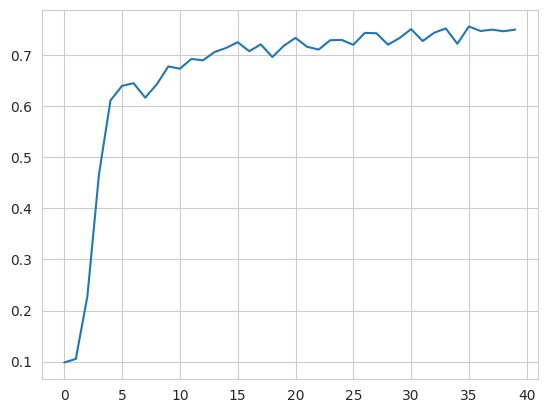

In [42]:
plt.plot(hist.history['val_accuracy'])

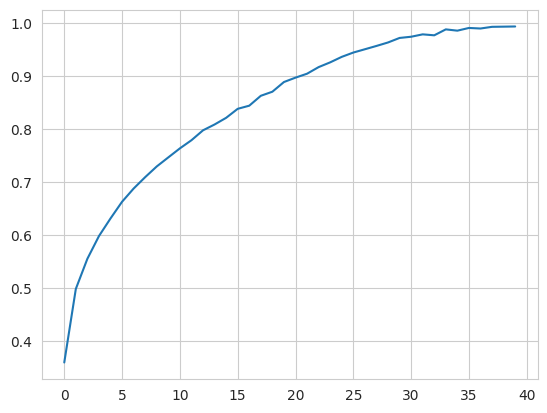

In [43]:
plt.plot(hist.history['accuracy'])

In [6]:
kernels.utils.make_pos_grid(3)

tensor([[[[-1, -1]]],


        [[[-1,  0]]],


        [[[-1,  1]]],


        [[[ 0, -1]]],


        [[[ 0,  0]]],


        [[[ 0,  1]]],


        [[[ 1, -1]]],


        [[[ 1,  0]]],


        [[[ 1,  1]]]])

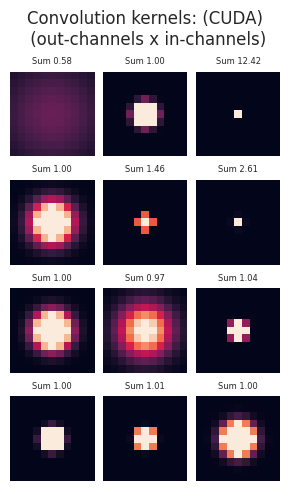

In [7]:
torch.manual_seed(0)
kernels.GaussKernelIso2D(3, 4, kernel_size=11, init="normal").to(device).plot()

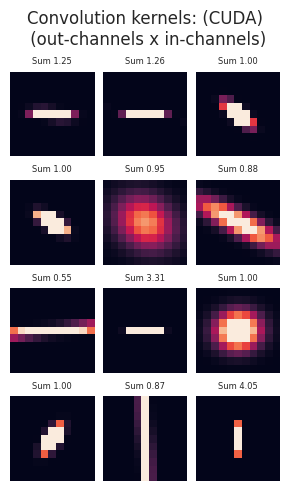

In [8]:
torch.manual_seed(0)
kernels.GaussKernelMulti2D(3, 4, kernel_size=11, init="normal").to(device).plot()

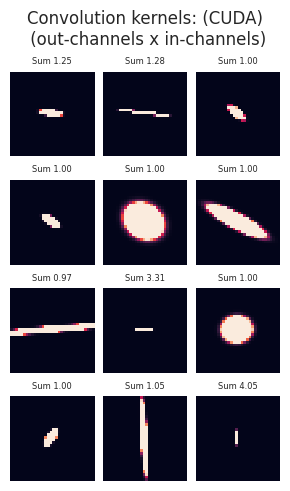

In [9]:
torch.manual_seed(0)
kernels.GaussKernelMulti2D(3, 4, kernel_size=32, init="normal").to(device).plot()

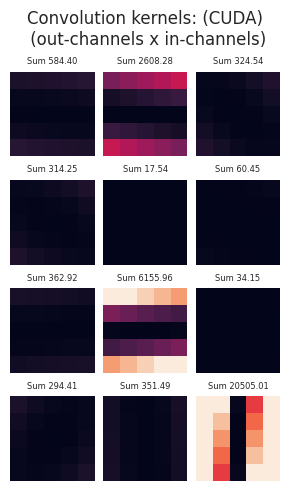

In [10]:
torch.manual_seed(0)
kernels.QuadraticKernelMulti2D(3, 4, kernel_size=5, init="normal").to(device).plot()

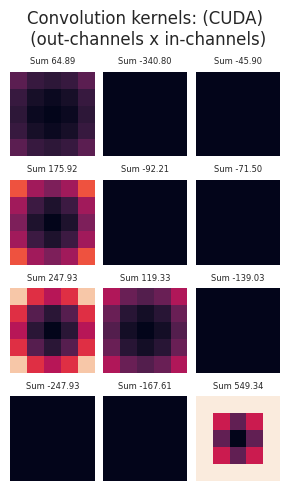

In [17]:
torch.manual_seed(0)
kernels.QuadraticKernelIso2D(3, 4, kernel_size=5, init="normal").to(device).plot()

In [19]:
class SimpleConvClassifier(nn.Module):
    def __init__(
            self,
            conv_type: Callable[[int, int, int], nn.Module],
            kernel_sizes: Iterable[int],
            planes: Iterable[int],
            img_channels: int = 3,
            img_dims: int = 2,
            activate_first: bool = True,
            *,
            out_classes: int,
    ):
        super().__init__()
        params = chain(((-1, img_channels),), zip(kernel_sizes, planes, strict=True))
        convs = []
        activate = activate_first
        for (_, in_channels), (kernel_size, out_channels) in pairwise(params):
            convs.append(conv_type(in_channels, out_channels, kernel_size))
            if activate:
                convs.append(nn.ReLU6())
            activate = True

        self.convs = nn.Sequential(*convs)
        self.lin = nn.LazyLinear(out_classes)
        self.img_dims = img_dims

    def forward(self, x: torch.Tensor) -> torch.distributions.Categorical:
        x = self.convs(x)
        x = x.mean([img_dim for img_dim in range(-self.img_dims, 0)])
        x = self.lin(x)
        x = torch.distributions.Categorical(logits=x)
        return x


test_cls = SimpleConvClassifier(nn.Conv2d, (7, 3, 5), (10, 20, 60), out_classes=10).to(
    device
)
test_cat = test_cls(torch.ones((5, 3, 50, 50), device=device))
print(test_cls)
print(test_cat)
test_cat.log_prob(torch.tensor([1, 2, 3, 4, 5], device=device))

SimpleConvClassifier(
  (convs): Sequential(
    (0): Conv2d(3, 10, kernel_size=(7, 7), stride=(1, 1))
    (1): ReLU6()
    (2): Conv2d(10, 20, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU6()
    (4): Conv2d(20, 60, kernel_size=(5, 5), stride=(1, 1))
    (5): ReLU6()
  )
  (lin): Linear(in_features=60, out_features=10, bias=True)
)
Categorical(logits: torch.Size([5, 10]))


tensor([-2.2508, -2.2790, -2.3604, -2.3533, -2.2839], device='cuda:0',
       grad_fn=<SqueezeBackward1>)

In [20]:
def _generic_conv(
        kernel_cls: type[nn.Module], conv_cls: type[nn.Module], init: str = "normal"
):
    def _new(in_channels, out_channels, kernel_size):
        return convolutions.GenericConv2D(
            kernel=kernel_cls(in_channels, out_channels, kernel_size, init=init),
            conv=conv_cls(),
        )

    return _new

In [21]:
for kernel_type in (
        kernels.LearnedKernel,
        kernels.GaussKernelIso2D,
        kernels.GaussKernelMulti2D,
):
    test_cls = SimpleConvClassifier(
        _generic_conv(kernel_type, convolutions.LinearConv2D),
        (7, 3, 5),
        (10, 20, 60),
        out_classes=10,
    ).to(device)
    test_cat = test_cls(torch.ones((5, 3, 50, 50), device=device))
    print(test_cls)
    print(test_cat)
    print(test_cat.log_prob(torch.tensor([1, 2, 3, 4, 5], device=device)))
    print(sum(p.numel() for p in test_cls.parameters()), "parameters")
    print("\n===\n")

SimpleConvClassifier(
  (convs): Sequential(
    (0): GenericConv2D(
      (kernel): LearnedKernel()
      (conv): LinearConv2D()
    )
    (1): ReLU6()
    (2): GenericConv2D(
      (kernel): LearnedKernel()
      (conv): LinearConv2D()
    )
    (3): ReLU6()
    (4): GenericConv2D(
      (kernel): LearnedKernel()
      (conv): LinearConv2D()
    )
    (5): ReLU6()
  )
  (lin): Linear(in_features=60, out_features=10, bias=True)
)
Categorical(logits: torch.Size([5, 10]))
tensor([-6.0894, -5.2787, -0.6706, -1.2386, -7.8548], device='cuda:0',
       grad_fn=<SqueezeBackward1>)
33880 parameters

===

SimpleConvClassifier(
  (convs): Sequential(
    (0): GenericConv2D(
      (kernel): GaussKernelIso2D(3, 10, kernel_size=7)
      (conv): LinearConv2D()
    )
    (1): ReLU6()
    (2): GenericConv2D(
      (kernel): GaussKernelIso2D(10, 20, kernel_size=3)
      (conv): LinearConv2D()
    )
    (3): ReLU6()
    (4): GenericConv2D(
      (kernel): GaussKernelIso2D(20, 60, kernel_size=5)
      (

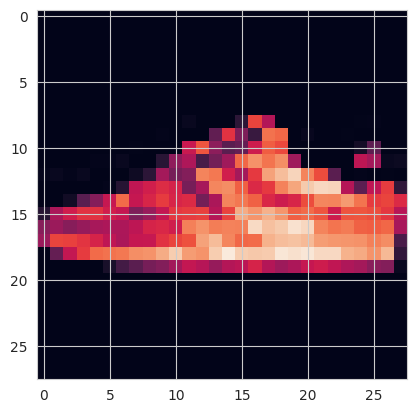

In [41]:
batch_size = 512
transform = torchvision.transforms.Compose(
    [
        torchvision.transforms.ToTensor(),
        torchvision.transforms.Normalize((0.5,), (0.5,)),
        # torchvision.transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
    ]
)
train_data = torchvision.datasets.FashionMNIST(
    root="./data", train=True, download=True, transform=transform
)
torch.manual_seed(0)
train_loader = torch.utils.data.DataLoader(
    train_data,
    batch_size=batch_size,
    shuffle=True,
)
plt.imshow(next(iter(train_loader))[0][batch_size - 1, 0])

In [23]:
def train_model(model: nn.Module, epcohs: int = 1, lr=1e-3):
    model.train()
    opt = torch.optim.Adam(model.parameters(), lr=lr)
    bar = tqdm.trange(epcohs, unit="epochs")
    model = model.to(device)
    losses = []
    for _epoch in bar:
        for imgs, ys in train_loader:
            imgs, ys = imgs.to(device), ys.to(device)
            opt.zero_grad()
            pred_dist: torch.distributions.Categorical = model(imgs)
            nll = -pred_dist.log_prob(ys).mean()
            nll.backward()
            opt.step()
            bar.set_postfix(loss=nll.detach().item())
            losses.append(nll.detach().item())
    return losses

  0%|          | 0/10 [00:00<?, ?epochs/s]

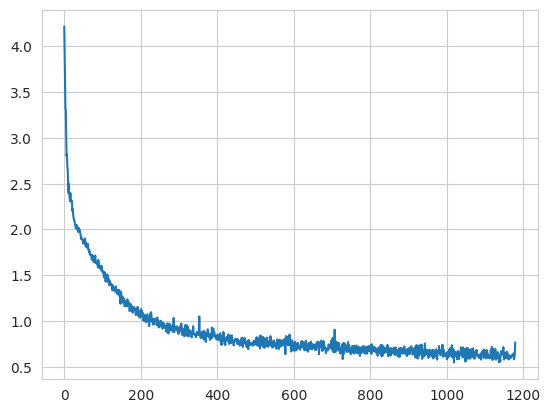

In [30]:
torch.manual_seed(0)
torch.set_float32_matmul_precision('high')
test_cls = SimpleConvClassifier(
    _generic_conv(kernels.LearnedKernel, convolutions.LinearConv2D),
    (7, 3, 5),
    (10, 20, 60),
    out_classes=10,
    img_channels=1,
)
test_cls.compile(fullgraph=True)

hist = train_model(test_cls, epcohs=10)
plt.plot(hist)

In [ ]:
kernels.utils.plot_kernels(test_cls.convs[2].kernel())

In [42]:
test_data = torchvision.datasets.FashionMNIST(
    root="./data", train=False, download=True, transform=transform
)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size)

In [91]:
from src import load_data

cifar10 = load_data.cifar10()

In [73]:
def _conv_layer(
        hp: keras_tuner.HyperParameters,
        layer_num: int,
        in_channels: int,
        out_channels: int,
        kernel_size: int,
        init: str,
        smoothing: bool = False,
):
    if smoothing:
        kernel_options = {
            "gauss-iso": kernels.GaussKernelIso2D,
            "gauss-multi": kernels.GaussKernelMulti2D,
        }
        kernel = kernel_options[
            hp.Choice(
                f"conv-{layer_num}-kernel",
                list(kernel_options.keys()),
                parent_name="do_smoothing",
                parent_values=(True,),
            )
        ]
    else:
        kernel = kernels.LearnedKernel

    return layers.TorchModuleWrapper(
        convolutions.GenericConv2D(
            kernel=kernel(
                in_channels=in_channels,
                out_channels=out_channels,
                kernel_size=kernel_size,
                init=init,
            ),
            conv=convolutions.LinearConv2D(),
        ),
        name=f"conv-{layer_num}",
    )


def _pool_layer(hp: keras_tuner.HyperParameters, layer_num: int,
                channels: int, init: str):
    if not hp.Boolean("quadratic-pooling"):
        pool_size = hp.Int(
            "classic-pool-size",
            2, 4,
            parent_name="quadratic-pooling",
            parent_values=(False,),
        )
        return layers.MaxPool2D(
            data_format="channels_first", pool_size=(pool_size, pool_size)
        )

    kernel_options = {
        "quadratic-iso": kernels.GaussKernelIso2D,
        "quadratic-multi": kernels.QuadraticKernelMulti2D,
    }
    kernel_kind: str = hp.Choice(
        "quadratic-pool-kernel",
        list(kernel_options),
        parent_name="quadratic-pooling",
        parent_values=(True,),
    )
    kernel = kernel_options[kernel_kind]
    if hp.Boolean(
            "quadratic-pool-softpool", parent_name="quadratic-pooling", parent_values=(True,)
    ):
        soft_temp = hp.Float("quadratic-pool-softpool-temp", 1, 1e5, sampling="log", step=10,
                             parent_name="quadratic-pool-softpool", parent_values=(True,))
    else:
        soft_temp = None

    pool_size = hp.Int(
        "quadratic-pool-size",
        3, 7, step=2,
        parent_name="quadratic-pooling",
        parent_values=(True,),
    )
    return layers.TorchModuleWrapper(
        convolutions.GenericConv2D(
            kernel=kernel(
                in_channels=1, out_channels=channels, kernel_size=pool_size, init=init
            ),
            conv=convolutions.TropicalConv2D(is_max=True, softmax_temp=soft_temp),
        ),
        name=f"quadratic-{kernel_kind.removeprefix('quadratic-')}-pool-{layer_num}",
    )


def build_model(hp: keras_tuner.HyperParameters) -> keras.Model:
    img_channels: int = 3
    num_classes: int = 10
    init_kind = hp.Choice("init_kind", ["normal"])

    model = keras.Sequential()
    model.add(
        layers.TorchModuleWrapper(
            convolutions.CoerceImage4D(img_channels), name="reshape"
        )
    )
    if hp.Boolean("do_smoothing"):
        model.add(
            _conv_layer(
                hp,
                0,
                in_channels=img_channels,
                out_channels=10,
                kernel_size=7,
                init=init_kind,
                smoothing=True,
            )
        )
        first_channels = 10
    else:
        first_channels = img_channels

    model.add(
        _conv_layer(
            hp,
            1,
            in_channels=first_channels,
            out_channels=20,
            kernel_size=5,
            init=init_kind,
        )
    )
    model.add(layers.ReLU())
    model.add(_pool_layer(hp, 1, channels=20, init=init_kind))

    model.add(
        _conv_layer(
            hp, 2, in_channels=20, out_channels=50, kernel_size=5, init=init_kind
        )
    )
    model.add(layers.ReLU())
    model.add(_pool_layer(hp, 2, channels=50, init=init_kind))

    model.add(layers.Flatten())
    if hp.Boolean("logit-hidden"):
        model.add(layers.Dense(
            hp.Choice("logit-hidden-size", (500,), parent_name="logit-hidden", parent_values=(True,)),
            name="logit-hidden"))
        model.add(layers.ReLU())

    model.add(layers.Dense(num_classes, name="logit-predictor"))

    model.compile(
        optimizer=keras.optimizers.Adam(),
        loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
        metrics=[
            "accuracy",
            keras.metrics.SparseTopKCategoricalAccuracy(k=3, name="top3"),
        ],
    )
    return model


test_hp = keras_tuner.HyperParameters()
test_hp.Fixed("quadratic-pooling", True)
test_model = build_model(test_hp)
test_res = test_model(cifar10.x_train[:512]).numpy(force=True)
print(test_res.shape)
test_model.summary()

(512, 10)


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ reshape (TorchModuleWrapper)    │ (512, 3, 32, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv-1 (TorchModuleWrapper)     │ (512, 20, 28, 28)      │         1,500 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_6 (ReLU)                  │ (512, 20, 28, 28)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ quadratic-iso-pool-1            │ (512, 20, 26, 26)      │            20 │
│ (TorchModuleWrapper)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv-2 (TorchModuleWrapper)     │ (512, 50, 22, 22)      │        25,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_7 (ReLU)                  │ (512, 50, 22, 22)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ quadratic-iso-pool-2            │ (512, 50, 20, 20)      │            50 │
│ (TorchModuleWrapper)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (512, 20000)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ logit-predictor (Dense)         │ (512, 10)              │       200,010 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 226,580 (885.08 KB)

 Trainable params: 226,580 (885.08 KB)

 Non-trainable params: 0 (0.00 B)

In [43]:
test_data.data

tensor([[[0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         ...,
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0]],

        [[0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         ...,
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0]],

        [[0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         ...,
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0]],

        ...,

        [[0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         ...,
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0]],

        [[0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0,

array([[[-1., -1., -1., ..., -1., -1., -1.],
        [-1., -1., -1., ..., -1., -1., -1.],
        [-1., -1., -1., ..., -1., -1., -1.],
        ...,
        [-1., -1., -1., ..., -1., -1., -1.],
        [-1., -1., -1., ..., -1., -1., -1.],
        [-1., -1., -1., ..., -1., -1., -1.]],

       [[-1., -1., -1., ..., -1., -1., -1.],
        [-1., -1., -1., ..., -1., -1., -1.],
        [-1., -1., -1., ..., -1., -1., -1.],
        ...,
        [-1., -1., -1., ..., -1., -1., -1.],
        [-1., -1., -1., ..., -1., -1., -1.],
        [-1., -1., -1., ..., -1., -1., -1.]],

       [[-1., -1., -1., ..., -1., -1., -1.],
        [-1., -1., -1., ..., -1., -1., -1.],
        [-1., -1., -1., ..., -1., -1., -1.],
        ...,
        [-1., -1., -1., ..., -1., -1., -1.],
        [-1., -1., -1., ..., -1., -1., -1.],
        [-1., -1., -1., ..., -1., -1., -1.]],

       ...,

       [[-1., -1., -1., ..., -1., -1., -1.],
        [-1., -1., -1., ..., -1., -1., -1.],
        [-1., -1., -1., ..., -1., -1., -1.

In [108]:
keras.utils.set_random_seed(0)
test_hp = keras_tuner.HyperParameters()
test_hp.Fixed("quadratic-pooling", True)
test_hp.Fixed("quadratic-pool-kernel", "quadratic-multi")
# test_hp.Fixed("logit-hidden", True)
test_model = build_model(test_hp)
hist = test_model.fit(
    x=cifar10.x_train,
    y=cifar10.y_train,
    batch_size=2 ** 8,
    epochs=20,
    verbose=False,
    validation_split=0.3,
)

In [83]:
import numpy as np


In [109]:
hist.history

{'accuracy': [0.32765713334083557,
  0.4324856996536255,
  0.4913142919540405,
  0.5413428544998169,
  0.5862857103347778,
  0.6162285804748535,
  0.6506285667419434,
  0.6869142651557922,
  0.7241714000701904,
  0.7474571466445923,
  0.774142861366272,
  0.7935143113136292,
  0.8219714164733887,
  0.8430285453796387,
  0.8475714325904846,
  0.8629428744316101,
  0.8764285445213318,
  0.8920000195503235,
  0.8924285769462585,
  0.8924000263214111],
 'loss': [43.568294525146484,
  8.296493530273438,
  5.206256866455078,
  3.409863233566284,
  2.440972328186035,
  1.897752046585083,
  1.519041657447815,
  1.2043238878250122,
  0.9691423177719116,
  0.832684338092804,
  0.7198655009269714,
  0.6357399821281433,
  0.5330173373222351,
  0.45710819959640503,
  0.43936508893966675,
  0.3882533609867096,
  0.3488995432853699,
  0.3048880100250244,
  0.3000350296497345,
  0.2937464416027069],
 'top3': [0.6444857120513916,
  0.7504857182502747,
  0.800428569316864,
  0.8372856974601746,
  0.8668

(array([ 9209880., 14648032., 19461640., 20746326., 21797296., 19253251.,
        16802935., 12526267.,  9606551.,  9547822.]),
 array([-0.5       , -0.40039062, -0.30078125, -0.20117188, -0.1015625 ,
        -0.00195312,  0.09765625,  0.19726562,  0.296875  ,  0.39648438,
         0.49609375]),
 <BarContainer object of 10 artists>)

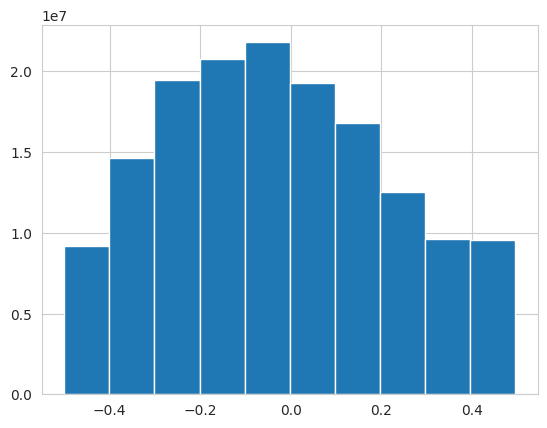

In [130]:
import importlib

# load_data = importlib.reload(load_data)
cifar10 = load_data.cifar10()
plt.hist(cifar10.x_train.flatten())

(array([5775123.,  188615.,  155376.,  137140.,  137956.,  132042.,
         143123.,  150072.,  193146.,  827407.]),
 array([-0.5       , -0.40039062, -0.30078125, -0.20117188, -0.1015625 ,
        -0.00195312,  0.09765625,  0.19726562,  0.296875  ,  0.39648438,
         0.49609375]),
 <BarContainer object of 10 artists>)

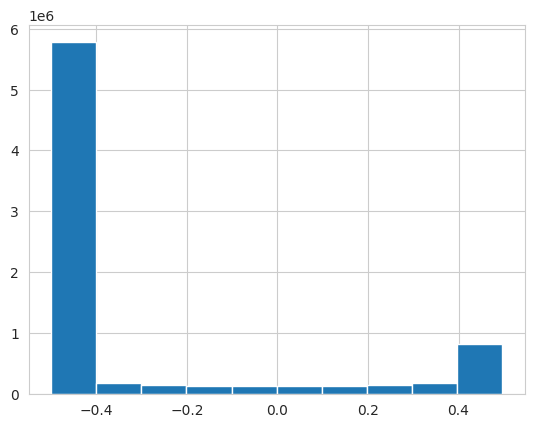

In [132]:
plt.hist(load_data.k_mnist().x_test.flatten())

In [123]:
td

tensor([[[  0,   0,   0,  ...,   0,   0,   0],
         [  0,   0,   0,  ...,   0,   0,   0],
         [  0,   0,   0,  ...,   0,   0,   0],
         ...,
         [  0,   0,   0,  ...,   0,   0,   0],
         [  0,   0,   0,  ...,   0,   0,   0],
         [  0,   0,   0,  ...,   0,   0,   0]],

        [[  0,   0,   0,  ...,   0,   0,   0],
         [  0,   0,   0,  ...,   0,   0,   0],
         [  0,   0,   0,  ...,   0,   0,   0],
         ...,
         [  0,   0,   0,  ...,   0,   0,   0],
         [  0,   0,   0,  ...,   0,   0,   0],
         [  0,   0,   0,  ...,   0,   0,   0]],

        [[  0,   0,   0,  ...,   0,   0,   0],
         [  0,   0,   0,  ...,   0,   0,   0],
         [  0,   0,   0,  ...,   0,   0,   0],
         ...,
         [  0,   0,   0,  ...,   0,   0,   0],
         [  0,   0,   0,  ...,   0,   0,   0],
         [  0,   0,   0,  ...,   0,   0,   0]],

        ...,

        [[  0,   0,   0,  ...,   0,   0,   0],
         [  0,   0,   0,  ...,   0,   0,   0]

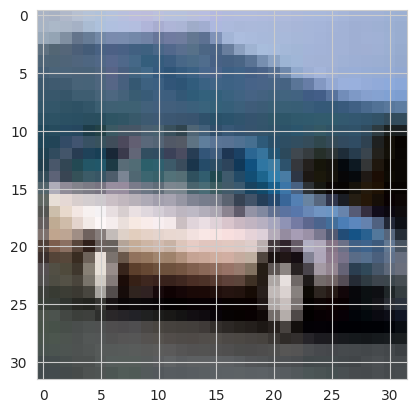

In [116]:
plt.imshow(np.moveaxis(cifar10.x_train[4], 0, 2) + 0.5)

In [15]:
test_hp = keras_tuner.HyperParameters()
test_hp.Fixed("quadratic-pooling", True)
test_hp.Fixed("quadratic-pool-kernel", "quadratic-multi")
tuner = keras_tuner.GridSearch(
    hypermodel=build_model,
    objective="val_accuracy",
    max_trials=1,
    seed=0,
    executions_per_trial=3,
    overwrite=True,
    directory="checkpoints",
    project_name="test",
    hyperparameters=test_hp
)
tuner.search_space_summary()

Search space summary
Default search space size: 8
quadratic-pooling (Fixed)
{'conditions': [], 'value': True}
quadratic-pool-kernel (Fixed)
{'conditions': [], 'value': 'quadratic-multi'}
init_kind (Choice)
{'default': 'normal', 'conditions': [], 'values': ['normal'], 'ordered': False}
do_smoothing (Boolean)
{'default': False, 'conditions': []}
quadratic-pool-kernel (Choice)
{'default': 'quadratic-iso', 'conditions': [{'class_name': 'Parent', 'config': {'name': 'quadratic-pooling', 'values': [True]}}], 'values': ['quadratic-iso', 'quadratic-multi'], 'ordered': False}
quadratic-pool-softpool (Boolean)
{'default': False, 'conditions': [{'class_name': 'Parent', 'config': {'name': 'quadratic-pooling', 'values': [True]}}]}
quadratic-pool-size (Int)
{'default': None, 'conditions': [{'class_name': 'Parent', 'config': {'name': 'quadratic-pooling', 'values': [True]}}], 'min_value': 3, 'max_value': 7, 'step': 2, 'sampling': 'linear'}
logit-hidden (Boolean)
{'default': False, 'conditions': []}


In [16]:
tuner.search(
    x=train_data.data,
    y=train_data.targets,
    batch_size=2 ** 8,
    epochs=20,
    verbose=False,
    validation_split=0.3,
)

In [17]:
tuner.oracle.trials['0'].summary()

Trial 0 summary
Hyperparameters:
quadratic-pooling: True
quadratic-pool-kernel: quadratic-iso
init_kind: normal
do_smoothing: False
quadratic-pool-softpool: False
quadratic-pool-size: 3
logit-hidden: False
Score: 0.8549814820289612


In [87]:
test_hp = keras_tuner.HyperParameters()
test_hp.Fixed("smoothing", False)
tuner.oracle.get_trial("2").hyperparameters.values

{'init_kind': 'normal', 'do_smoothing': True, 'conv-0-kernel': 'gauss-mulit'}

In [69]:
trd2 = torchvision.datasets.CIFAR100(
    root="./data", train=True, download=True
)

100%|██████████| 169M/169M [00:22<00:00, 7.46MB/s] 


In [58]:
a: torch.Tensor = torchvision.transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))(
    torch.tensor(trd2.data, dtype=torch.float32).movedim(3, 1))
a.nbytes

614400000

In [24]:
trd2_data = trd2.data.moveaxis(-1, 1)
trd2_data.shape

AttributeError: 'numpy.ndarray' object has no attribute 'moveaxis'

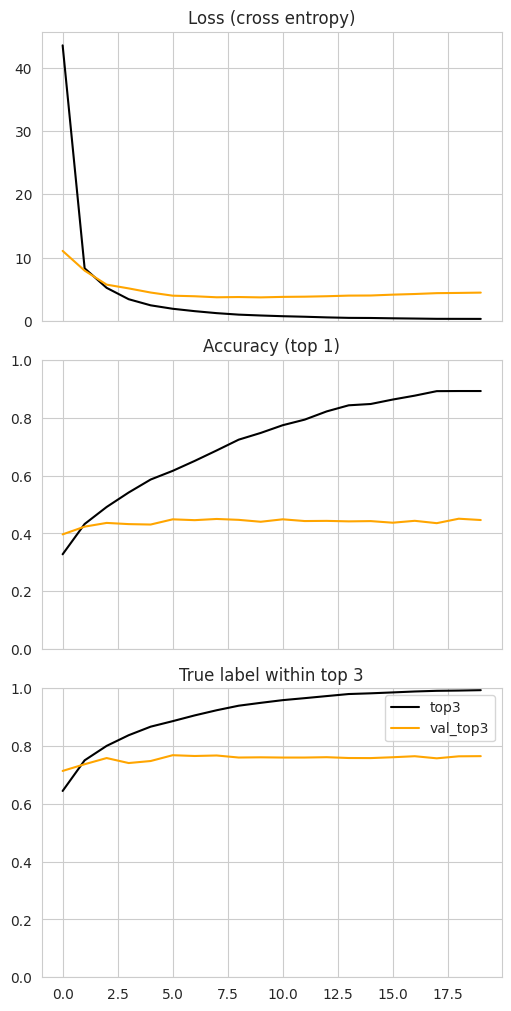

In [110]:
def show_history(dct: dict[str, list[float]]):
    _, (ax_loss, ax_acc, ax_top3) = plt.subplots(
        nrows=3, layout="compressed", figsize=(5, 10), sharex=True
    )

    for hist_k, hist_vs in dct.items():
        color = "orange" if "val" in hist_k else "black"
        if "loss" in hist_k:
            ax_loss.plot(hist_vs, label=hist_k, color=color)
        elif "top3" in hist_k:
            ax_top3.plot(hist_vs, label=hist_k, color=color)
        else:
            ax_acc.plot(hist_vs, label=hist_k, color=color)
    ax_loss.set_ylim((0, None))
    ax_acc.set_ylim((0, 1))
    ax_top3.set_ylim((0, 1))
    ax_top3.set_title("True label within top 3")
    ax_loss.set_title("Loss (cross entropy)")
    ax_acc.set_title("Accuracy (top 1)")
    plt.legend()
    plt.show()


show_history(hist.history)

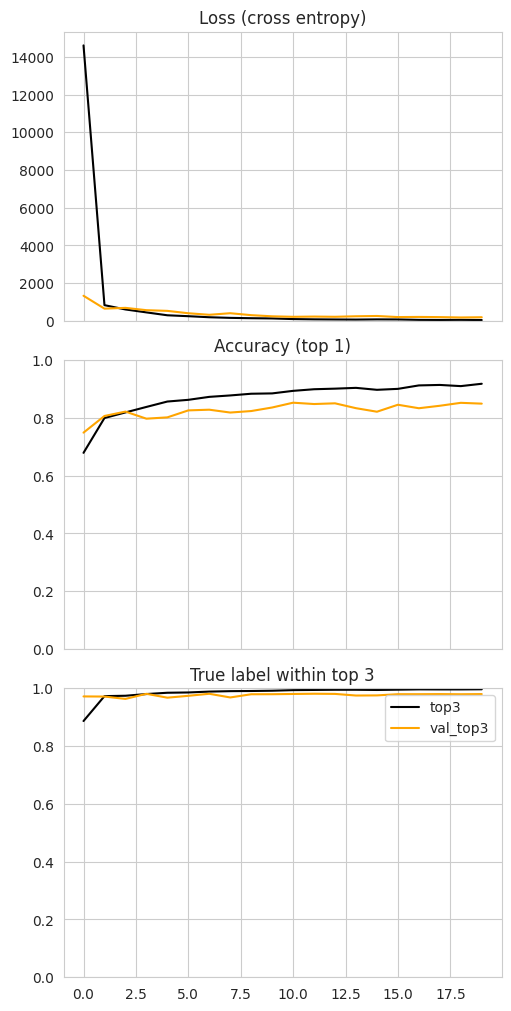

In [51]:
show_history(hist.history)

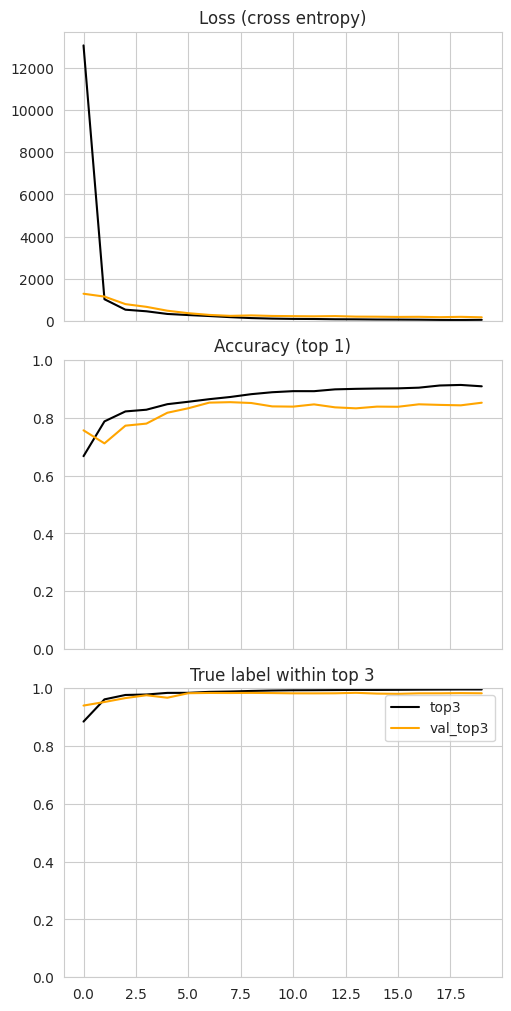

In [64]:
show_history(hist.history)

In [65]:
# multi
test_model.evaluate(x=test_data.data, y=test_data.targets, batch_size=2 ** 8)


40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8438 - loss: 181.9728 - top3: 0.9803


[179.42210388183594, 0.8453999757766724, 0.98089998960495]

In [55]:
# non-quadratic
test_model.summary()
test_model.evaluate(x=test_data.data, y=test_data.targets, batch_size=2 ** 8)

Model: "sequential_16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ reshape (TorchModuleWrapper)    │ (256, 1, 28, 28)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv-1 (TorchModuleWrapper)     │ (256, 20, 24, 24)      │           500 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_33 (ReLU)                 │ (256, 20, 24, 24)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (256, 20, 12, 12)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv-2 (TorchModuleWrapper)     │ (256, 50, 8, 8)        │        25,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_34 (ReLU)                 │ (256, 50, 8, 8)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (256, 50, 4, 4)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_13 (Flatten)            │ (256, 800)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ logits-predictor (Dense)        │ (256, 10)              │         8,010 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 100,532 (392.70 KB)

 Trainable params: 33,510 (130.90 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 67,022 (261.80 KB)

40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8237 - loss: 233.3044 - top3: 0.9768


[231.63526916503906, 0.8259000182151794, 0.9764999747276306]

In [74]:
test_model.summary()

Model: "sequential_23"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ reshape (TorchModuleWrapper)    │ (512, 1, 28, 28)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv-1 (TorchModuleWrapper)     │ (512, 20, 24, 24)      │           500 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_46 (ReLU)                 │ (512, 20, 24, 24)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ quadratic-iso-pool-1            │ (512, 20, 22, 22)      │            20 │
│ (TorchModuleWrapper)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv-2 (TorchModuleWrapper)     │ (512, 50, 18, 18)      │        25,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_47 (ReLU)                 │ (512, 50, 18, 18)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ quadratic-iso-pool-2            │ (512, 50, 16, 16)      │            50 │
│ (TorchModuleWrapper)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_19 (Flatten)            │ (512, 12800)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ logits-predictor (Dense)        │ (512, 10)              │       128,010 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 153,580 (599.92 KB)

 Trainable params: 153,580 (599.92 KB)

 Non-trainable params: 0 (0.00 B)

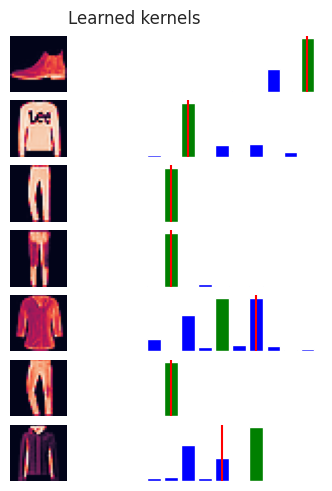

In [44]:
@torch.no_grad()
def plot_predictions(model: nn.Module, num_preds: int = 7, name: str = None):
    model.eval()
    assert num_preds <= batch_size
    imgs, ys = next(iter(test_loader))
    imgs, ys = imgs[:num_preds].to(device), ys[:num_preds].to(device)
    probs = model.to(device)(imgs).probs.cpu()
    fig, axs = plt.subplots(len(probs), 2, layout="compressed")
    for img, y, prob, (img_ax, prob_ax) in zip(
            imgs.cpu(), ys.cpu(), probs, axs, strict=True
    ):
        prob_ax: plt.Axes
        img_ax.imshow(img[0])
        prob_ax.bar(
            range(10),
            prob,
            color=["green" if i == prob.argmax().item() else "blue" for i in range(10)],
        )
        prob_ax.axvline(y, color="red")
        img_ax.set_axis_off()
        prob_ax.set_axis_off()
    if name is not None:
        fig.suptitle(name)
    plt.show()


plot_predictions(test_cls, name="Learned kernels")

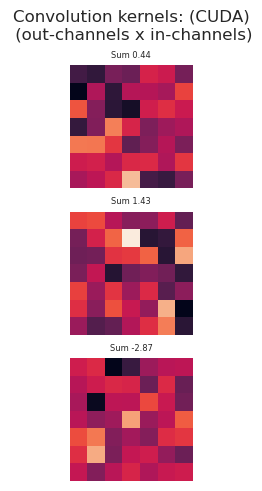

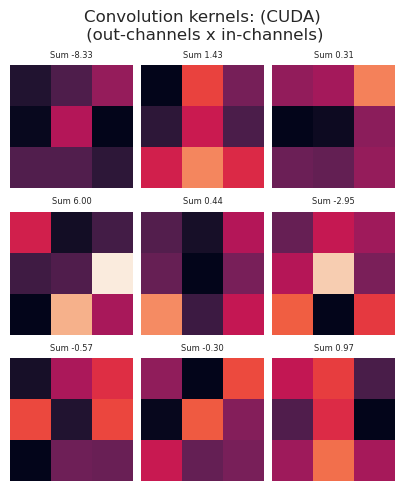

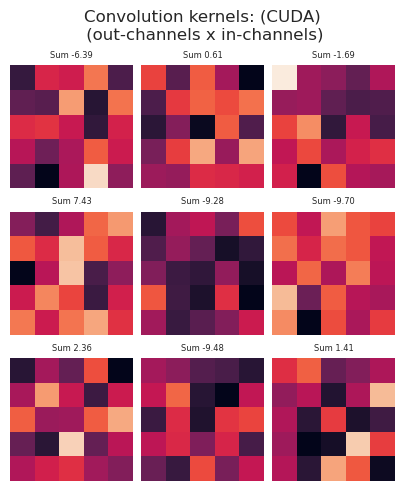

In [22]:
def plot_model_kernels(model: nn.Module, max_channels: int = 3, cut_zero=True):
    for conv in model.convs:
        if isinstance(conv, GenericConv2D):
            plot_kernels(
                conv.kernel()[:max_channels, :max_channels],
                cut_zero=cut_zero,
                high_cut=1.0,
            )


plot_model_kernels(test_cls, cut_zero=False)

In [23]:
@torch.no_grad()
def eval_accuracy(model: nn.Module, name: str = None):
    model.eval()
    model = model.to(device)
    if name is not None:
        print(f"Model: {name}")
    for data_name, data_loader in (("train", train_loader), ("test", test_loader)):
        top1 = 0
        top5 = 0
        count = 0
        for imgs, ys in data_loader:
            imgs, ys = imgs.to(device), ys.cpu()
            pred_labels: torch.distributions.Categorical = model(imgs)
            argsort_preds = pred_labels.probs.cpu().argsort(axis=1, descending=True)
            ranking = torch.empty_like(argsort_preds)
            ranking[torch.arange(len(ys)).unsqueeze(1), argsort_preds] = torch.arange(
                10
            ).unsqueeze(0)
            nth_rank = ranking[torch.arange(len(ys)), ys]
            count += len(nth_rank)
            top1 += (nth_rank < 1).sum().item()
            top5 += (nth_rank < 5).sum().item()

        print(f"Top1 ({data_name}):, {top1 / count:.1%}")
        print(f"Top5 ({data_name}):, {top5 / count:.1%}")


eval_accuracy(test_cls, name="Learned kernels")

Model: Learned kernels
Top1 (train):, 77.3%
Top5 (train):, 99.4%
Top1 (test):, 77.0%
Top5 (test):, 99.3%


In [24]:
def num_params(model: nn.Module):
    print(sum(p.numel() for p in model.parameters()), "parameters")


num_params(test_cls)

32900 parameters


  0%|          | 0/5 [00:00<?, ?epochs/s]

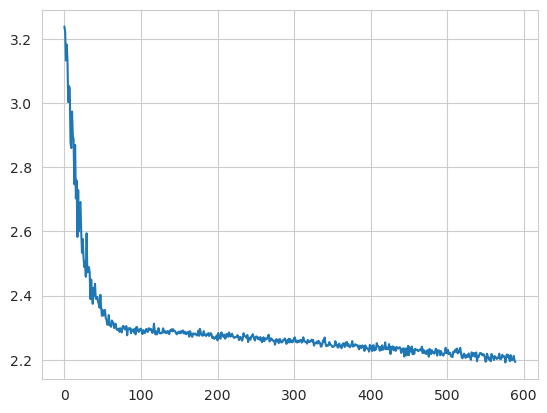

In [25]:
torch.manual_seed(0)
cls_iso = SimpleConvClassifier(
    _generic_conv(GaussKernelIso2D, LinearConv2D),
    (7, 3, 5),
    (50, 10, 10),
    out_classes=10,
    img_channels=1,
)
hist = train_model(cls_iso, epcohs=5)
plt.plot(hist)

Top1 (train):, 17.4%
Top5 (train):, 70.0%
Top1 (test):, 17.5%
Top5 (test):, 68.9%
760 parameters


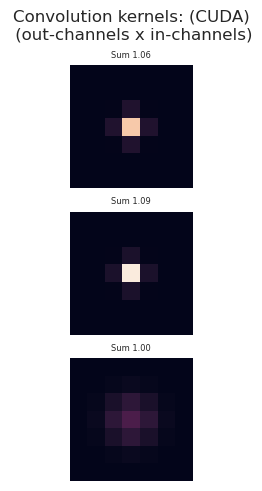

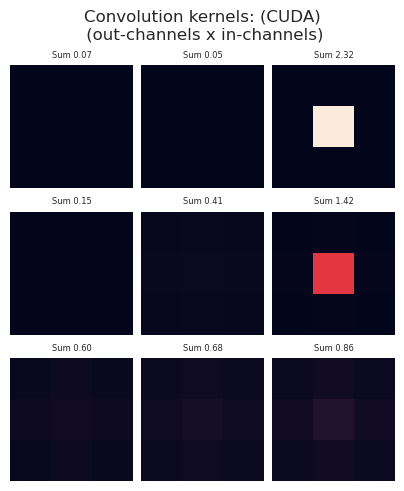

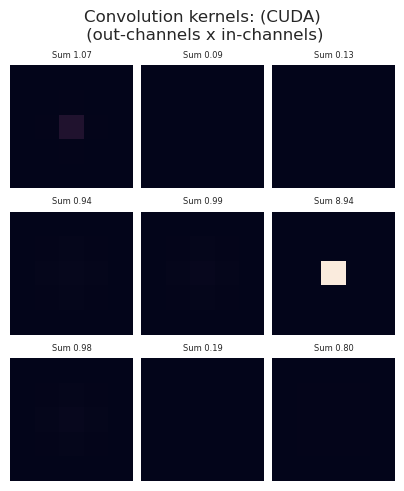

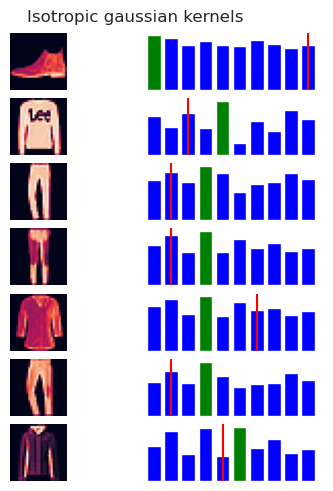

In [26]:
eval_accuracy(cls_iso)
num_params(cls_iso)
plot_model_kernels(cls_iso)
plot_predictions(cls_iso, name="Isotropic gaussian kernels")

  0%|          | 0/5 [00:00<?, ?epochs/s]

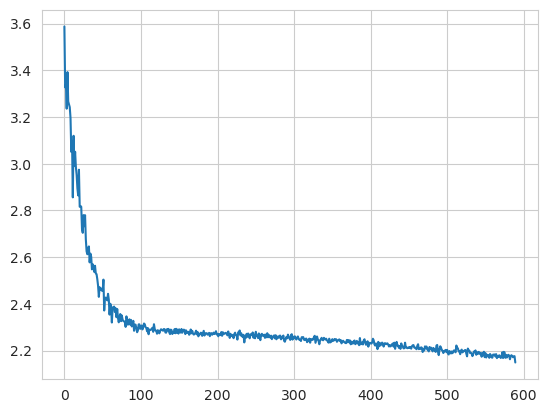

In [27]:
torch.manual_seed(0)
cls_multi = SimpleConvClassifier(
    _generic_conv(GaussKernelMulti2D, LinearConv2D),
    (10, 3, 5),
    (8, 8, 8),
    out_classes=10,
    img_channels=1,
)
hist = train_model(cls_multi, epcohs=5)
plt.plot(hist)

Top1 (train):, 21.9%
Top5 (train):, 69.0%
Top1 (test):, 22.2%
Top5 (test):, 68.5%
498 parameters


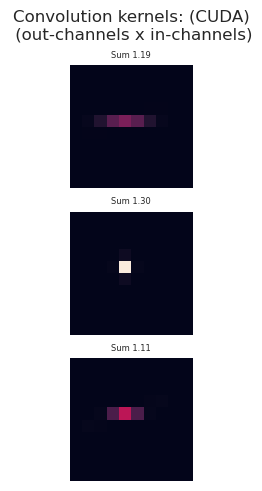

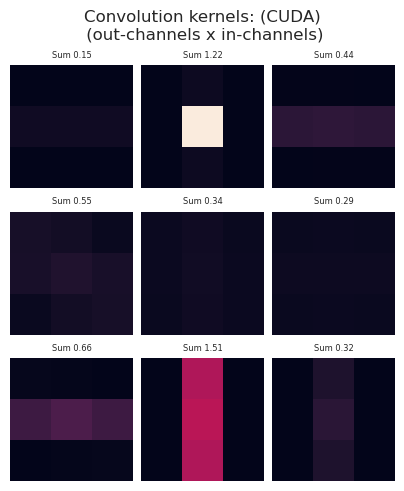

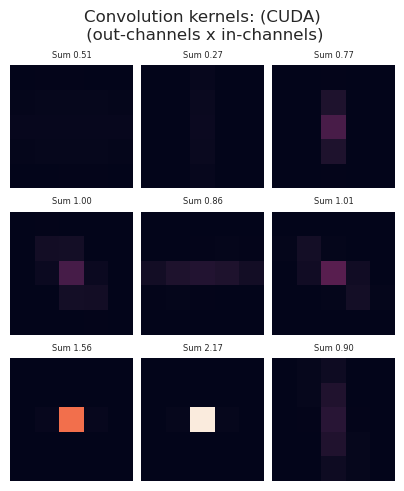

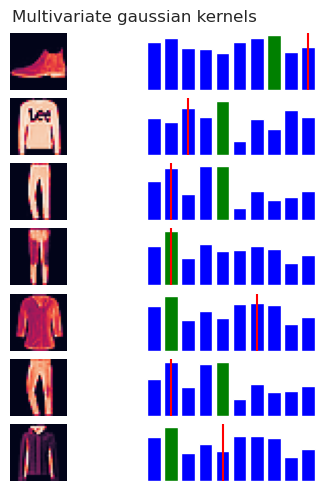

In [28]:
eval_accuracy(cls_multi)
num_params(cls_multi)
plot_model_kernels(cls_multi)
plot_predictions(cls_multi, name="Multivariate gaussian kernels")

In [29]:
def _generic_conv_diff_first(
        first_kernel_cls: type[nn.Module],
        kernel_cls: type[nn.Module],
        conv_cls: type[nn.Module],
        init: str = "normal",
):
    first = True

    def _new(in_channels, out_channels, kernel_size):
        nonlocal first
        cur = first_kernel_cls if first else kernel_cls
        first = False
        return GenericConv2D(
            kernel=cur(in_channels, out_channels, kernel_size, init=init),
            conv=conv_cls(),
        )

    return _new

  0%|          | 0/10 [00:00<?, ?epochs/s]

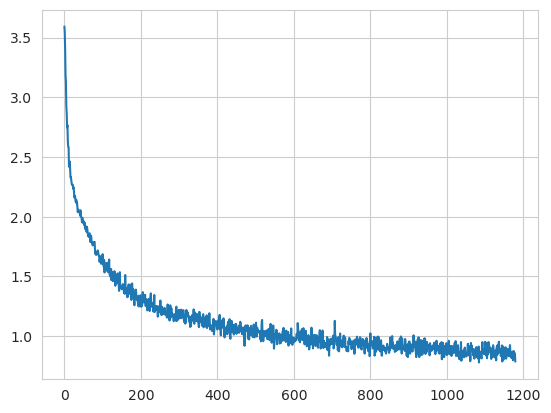

In [30]:
cls_iso_first = SimpleConvClassifier(
    _generic_conv_diff_first(GaussKernelIso2D, LearnedKernel, LinearConv2D),
    (7, 3, 5),
    (10, 20, 60),
    out_classes=10,
    img_channels=1,
)
hist = train_model(cls_iso_first, epcohs=10)
plt.plot(hist)

Top1 (train):, 69.7%
Top5 (train):, 97.7%
Top1 (test):, 69.7%
Top5 (test):, 97.5%
32420 parameters


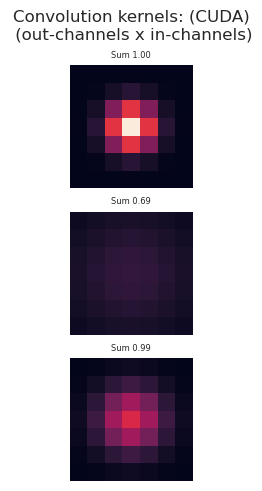

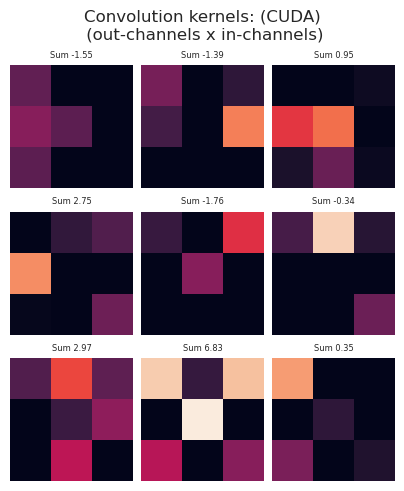

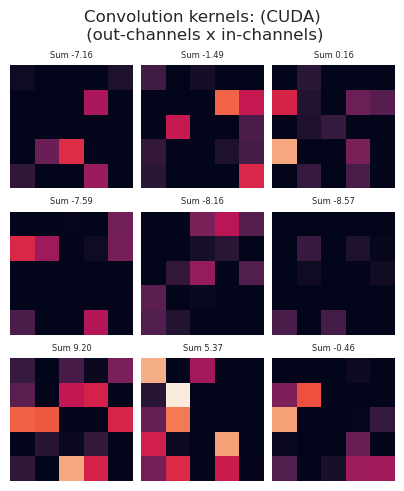

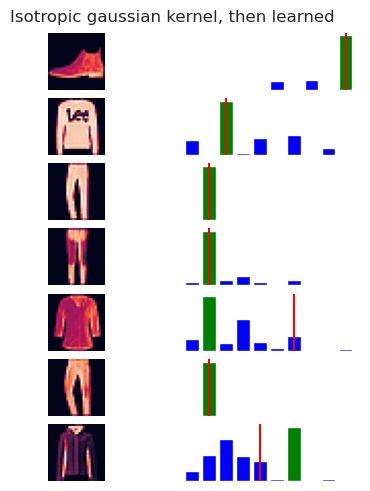

In [31]:
eval_accuracy(cls_iso_first)
num_params(cls_iso_first)
plot_model_kernels(cls_iso_first)
plot_predictions(cls_iso_first, name="Isotropic gaussian kernel, then learned")

  0%|          | 0/20 [00:00<?, ?epochs/s]

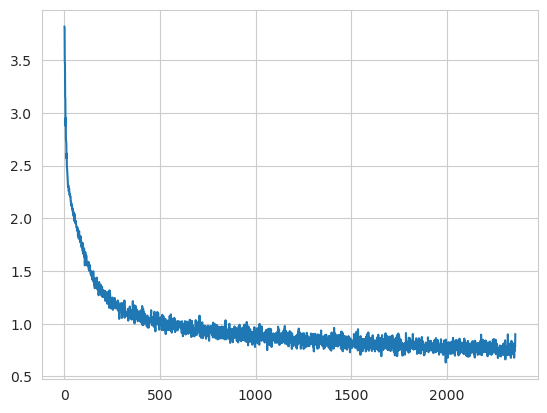

In [32]:
torch.manual_seed(0)
cls_multi_first = SimpleConvClassifier(
    _generic_conv_diff_first(GaussKernelMulti2D, LearnedKernel, LinearConv2D),
    (7, 3, 5),
    (10, 20, 60),
    out_classes=10,
    img_channels=1,
)
hist = train_model(cls_multi_first, epcohs=20)
plt.plot(hist)

Top1 (train):, 73.1%
Top5 (train):, 98.3%
Top1 (test):, 72.9%
Top5 (test):, 98.1%
32440 parameters


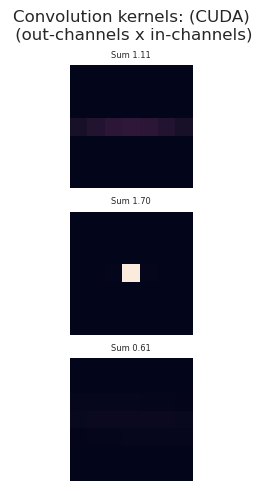

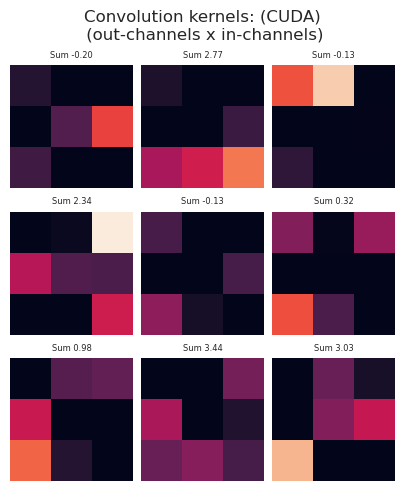

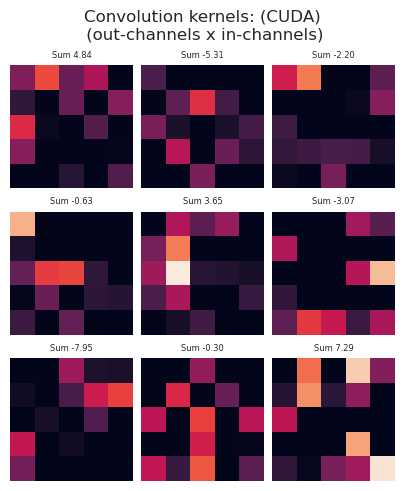

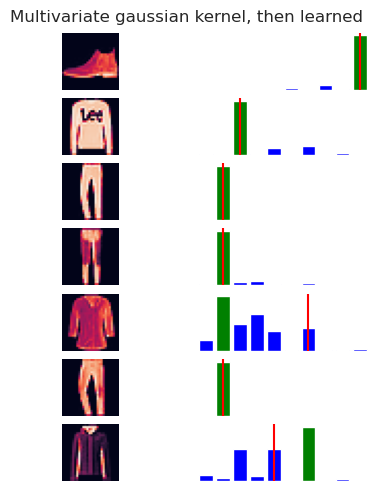

In [33]:
eval_accuracy(cls_multi_first)
num_params(cls_multi_first)
plot_model_kernels(cls_multi_first)
plot_predictions(cls_multi_first, name="Multivariate gaussian kernel, then learned")

  0%|          | 0/20 [00:00<?, ?epochs/s]

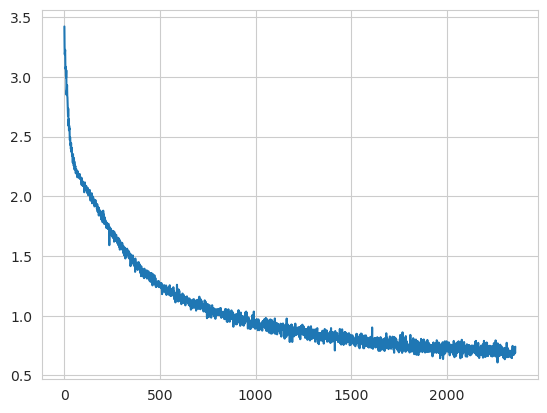

In [34]:
torch.manual_seed(0)
cls_small = SimpleConvClassifier(
    _generic_conv(LearnedKernel, LinearConv2D),
    (7, 3, 3),
    (8, 20, 10),
    out_classes=10,
    img_channels=1,
)
hist = train_model(cls_small, epcohs=20)
plt.plot(hist)

Top1 (train):, 75.0%
Top5 (train):, 99.3%
Top1 (test):, 74.2%
Top5 (test):, 99.1%
3742 parameters


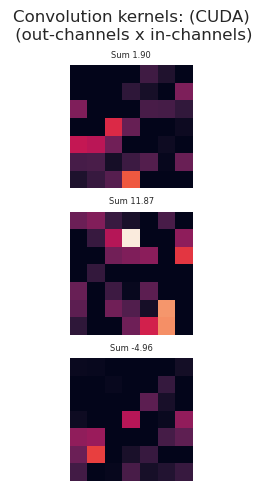

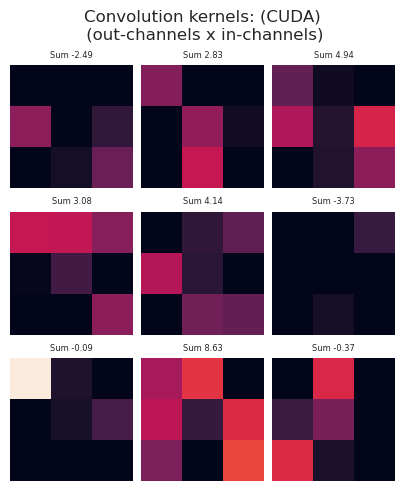

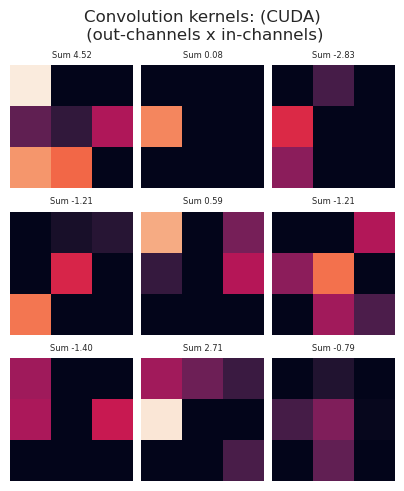

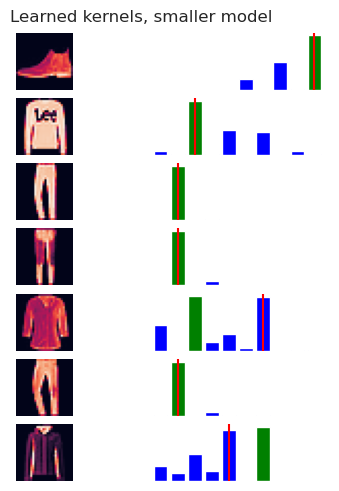

In [35]:
eval_accuracy(cls_small)
num_params(cls_small)
plot_model_kernels(cls_small)
plot_predictions(cls_small, name="Learned kernels, smaller model")

  0%|          | 0/20 [00:00<?, ?epochs/s]

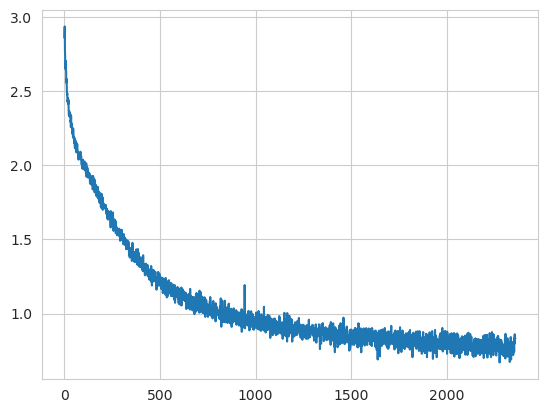

In [36]:
# Same as previous model, but with five (unactivated) scale spaces at the front
torch.manual_seed(0)
cls_small_iso = SimpleConvClassifier(
    _generic_conv_diff_first(GaussKernelIso2D, LearnedKernel, LinearConv2D),
    (7, 7, 3, 3),
    (5, 8, 20, 10),
    out_classes=10,
    img_channels=1,
    activate_first=False,
)
hist = train_model(cls_small_iso, epcohs=20)
plt.plot(hist)

Top1 (train):, 72.0%
Top5 (train):, 98.7%
Top1 (test):, 71.6%
Top5 (test):, 98.6%
5315 parameters


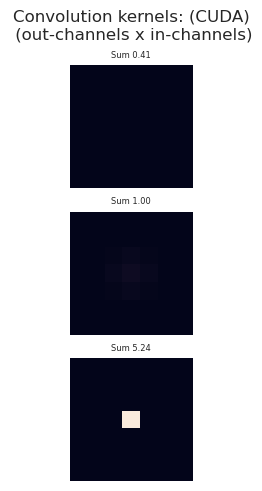

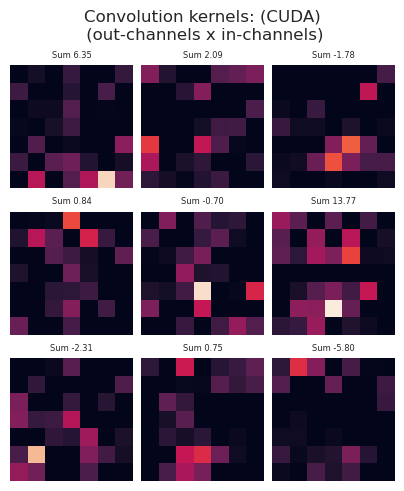

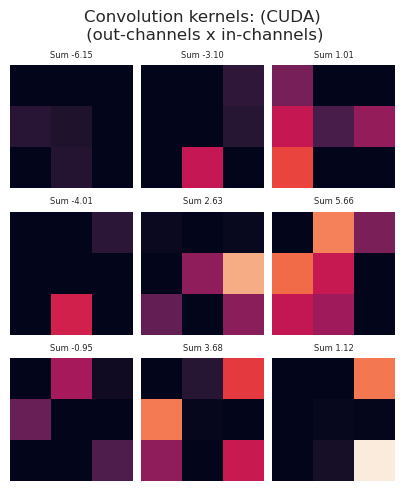

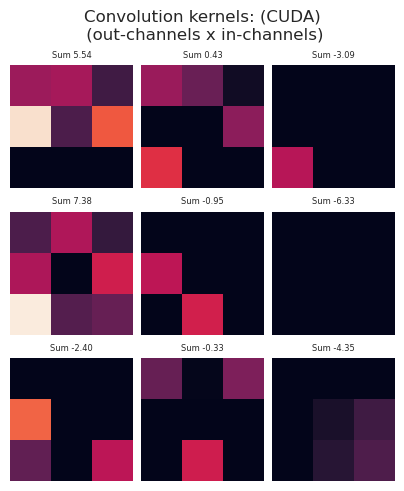

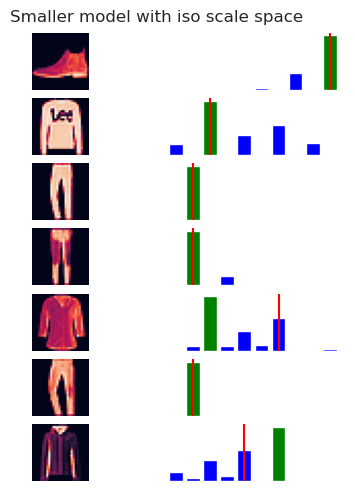

In [37]:
eval_accuracy(cls_small_iso)
num_params(cls_small_iso)
plot_model_kernels(cls_small_iso)
plot_predictions(cls_small_iso, name="Smaller model with iso scale space")

  0%|          | 0/20 [00:00<?, ?epochs/s]

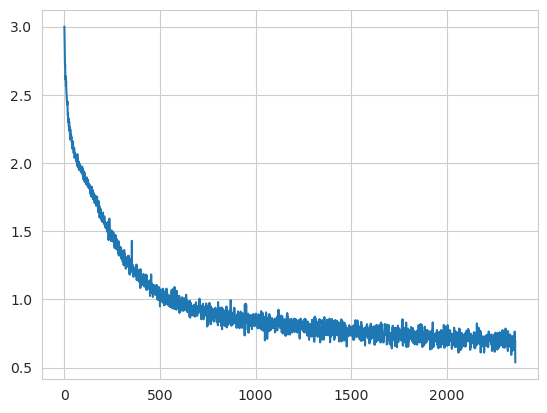

In [38]:
torch.manual_seed(0)
cls_small_multi = SimpleConvClassifier(
    _generic_conv_diff_first(GaussKernelMulti2D, LearnedKernel, LinearConv2D),
    (7, 7, 3, 3),
    (5, 8, 20, 10),
    out_classes=10,
    img_channels=1,
    activate_first=False,
)
hist = train_model(cls_small_multi, epcohs=20)
plt.plot(hist)

Top1 (train):, 73.6%
Top5 (train):, 99.2%
Top1 (test):, 73.0%
Top5 (test):, 98.9%
5325 parameters


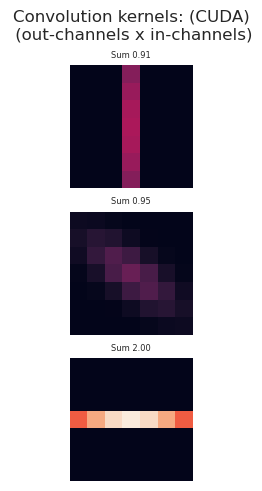

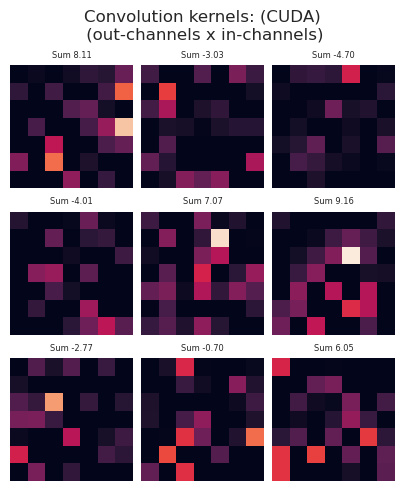

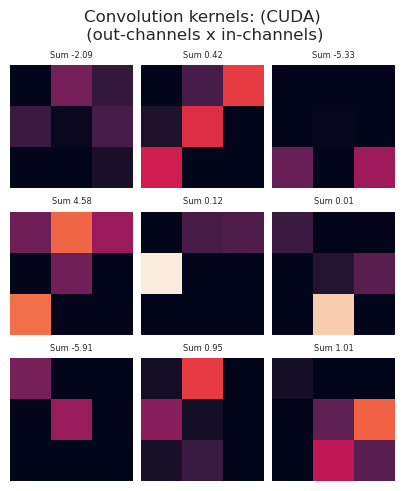

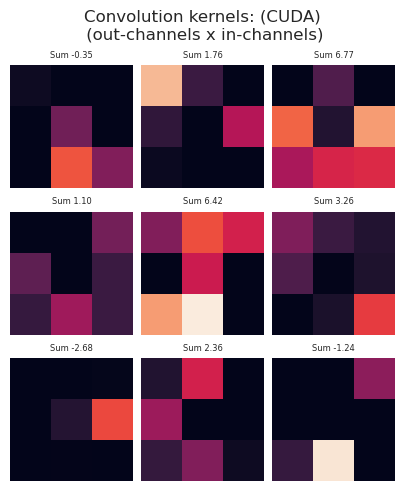

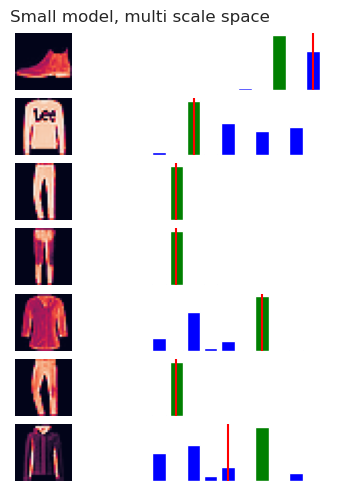

In [39]:
eval_accuracy(cls_small_multi)
num_params(cls_small_multi)
plot_model_kernels(cls_small_multi)
plot_predictions(cls_small_multi, name="Small model, multi scale space")